# Computer Exercise 3: Recursive Estimation and Models with Time-Varying Parameters

Time Series Analysis  
Lund University  
2025




This computer exercise treats recursive parameter estimation using Kalman filtering and recursive least squares. We attempt to model dynamic systems of both the SARIMA-type, having time-varying A and C polynomials, as well as to allow for ARMAX processes which have a synthetic input signal and time-varying B polynomial.

## Preparations before the lab

Read Chapter 8 in the course textbook as well as this guide to the computer exercise.

Answers to some of the computer exercise will be graded using the course's *Mozquizto* page, available at `https://quizms.maths.lth.se`. Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below *before the exercise*. These questions aim at allowing to check your implementation.

Before the computer exercise:

1. Express an AR(2) process on state space form and estimate the parameters of the process using a Kalman filter as specified in Sections 2.2 and 2.3.

2. Write a Python script that simulates the process $u_t$ in Section 2.4 below. Let $u_t$ be a Markov chain that switches slowly between two states, using $p_{11}=p_{22}=7/8$ and $p_{12}=p_{21}=1/8$.  
   Hint: This is easy to do using a loop where you at each time instance change state according to the specified probabilities.

Note that you are expected to be able to answer detailed questions on your implementation.

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal


# Import tsa_lth library
import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')
from tsa_lth.modelling import recursiveAR, recursiveARMA, filter, estimateARMA, PEM, polydiv
from tsa_lth.analysis import plotACFnPACF
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)



## 2.1 Recursive least squares estimation

Load the data material `tar2.dat`, the data is an AR(2)-process with one time dependent parameter and the other one constant. The correct parameter trajectories are stored in the file `thx.dat`. Use `subplot` to plot the data and the parameter in the same figure.

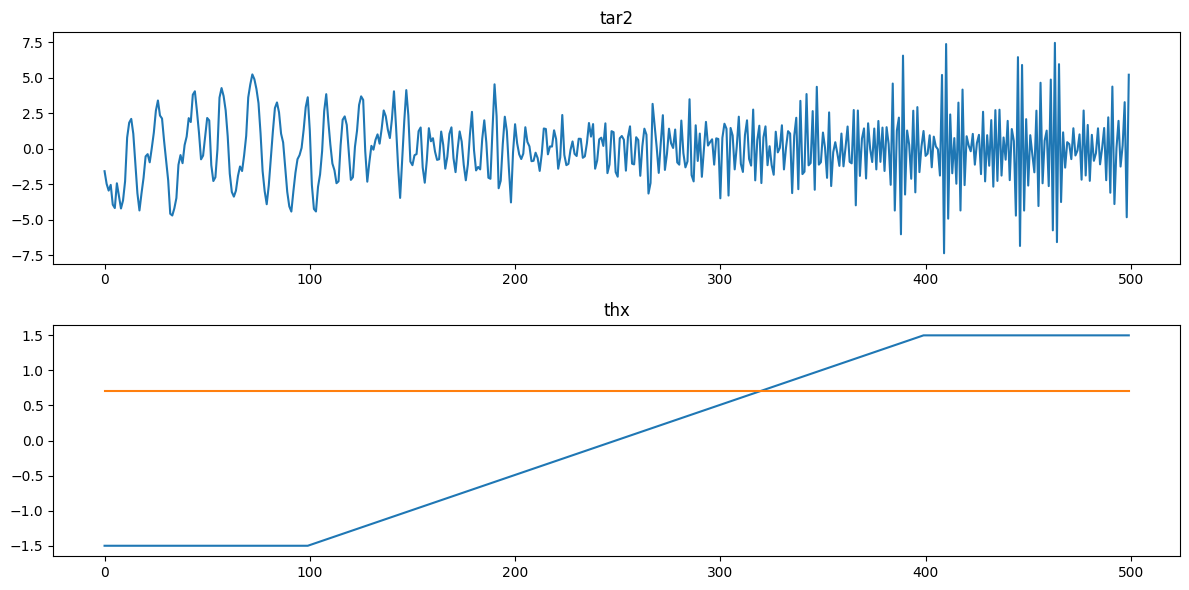

In [6]:
# Load data
tar2 = np.loadtxt('../data/tar2.dat')
thx = np.loadtxt('../data/thx.dat')

# Plot the data
plt.figure(1, figsize=(12, 6))
plt.subplot(211)
plt.plot(tar2)
plt.title('tar2')
plt.subplot(212)
plt.plot(thx)
plt.title('thx')
plt.tight_layout()
plt.show()

Use the Python `recursiveAR` to estimate the $A(z)$ polynomial recursively. Here, `Aest` is the estimated parameters, `yhat` is the estimate of $y_t$ based on the estimated $A(z)$ polynomial and past values of $y_t$. Try different forgetting factors, using ${\lambda}= 1,\, 0.95,\, 0.9$. Plot the parameter estimates together with the true parameter. What effect does the value of $\lambda$ have?

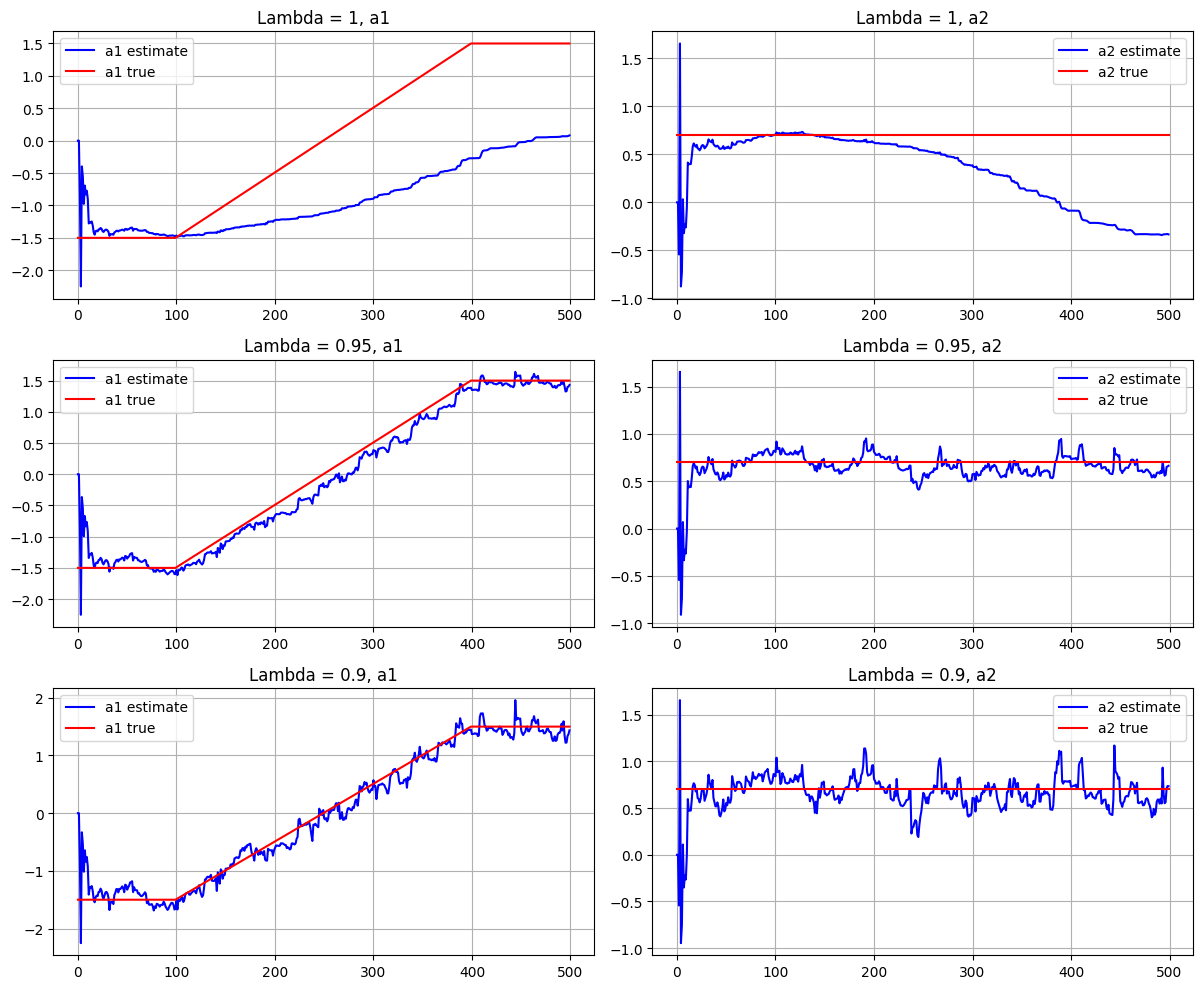

In [7]:
# Test different forgetting factors (lambdas)
lambdas = [1, 0.95, 0.9]

plt.figure(2, figsize=(12, 10))
for i, lam in enumerate(lambdas):
    # give it the data the model order, the forgetting factor and an initial guess for the parameters you can find the function in modeling.py
    Aest, yhat = recursiveAR(tar2, 2, forgetting_factor=lam, theta_guess=np.array([[0], [0]]))
    
    # Plot a1 parameter
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(Aest[:, 0], 'b', label='a1 estimate')
    plt.plot(thx[:, 0], 'r', label='a1 true')
    plt.title(f'Lambda = {lam}, a1')
    plt.legend()
    plt.grid(True)
    
    # Plot a2 parameter
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(Aest[:, 1], 'b', label='a2 estimate')
    plt.plot(thx[:, 1], 'r', label='a2 true')
    plt.title(f'Lambda = {lam}, a2')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

To choose $\lambda$, one option is to use the least squares estimate.

Min LS: 639.6315 ; lambda:0.9409


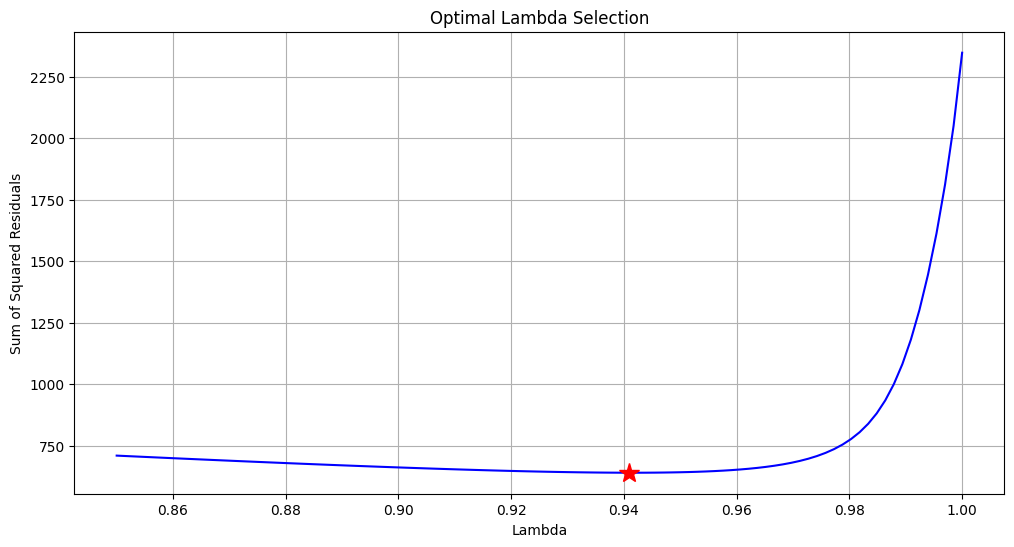

In [8]:
# Find optimal lambda
n = 100
lambda_line = np.linspace(0.85, 1, n)
ls2 = np.zeros(n)

for i in range(len(lambda_line)):
    Aest, yhat = recursiveAR(tar2, order=2, forgetting_factor=lambda_line[i], theta_guess=np.array([[0], [0]]))
    ls2[i] = np.sum((tar2 - yhat)**2)

# Find minimum
opt_ind = np.argmin(ls2)
lambda_opt = lambda_line[opt_ind]

print(f'Min LS: {ls2[opt_ind]:.4f} ; lambda:{lambda_opt:.4f}')

# Plot
plt.figure(3, figsize=(12, 6))
plt.plot(lambda_line, ls2, 'b-')
plt.plot(lambda_opt, ls2[opt_ind], 'r*', markersize=15)
plt.xlabel('Lambda')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimal Lambda Selection')
plt.grid(True)
plt.show()

**Question 1**  
In Mozquizto, answer question 1.

## 2.2 Kalman filtering of time series

A quite important drawback of the RLS estimate is that it should not be used to estimate MA parameters, making it unsuitable for, e.g., ARMA processes. We continue to again estimate the AR parameters from the previous section, but by using the Kalman filter. Note that the Kalman implementation can be extended to also allow for MA coefficients.

We here make use of the example code given in Section 3. At first, ignore the part of the example code for the 2-step prediction. This code uses data up to time $t-1$ to predict the state value $\hat{x}_{t|t-1}$, stored in the variable `x_t1`, and then use this value to predict (the one-step prediction) $\hat{y}_{t|t-1}$. The prediction error (also often termed the prediction residual) between $\hat{y}_{t|t-1}$ and $y_t$, i.e.,
$$
\epsilon_{t|t} = y_t - \hat{y}_{t|t-1}
$$
is then used to update the Kalman filter. Here, the prediction residual is stored in the variable `ehat`.

Proceed to complete the missing part of the code (ignore the part for the 2-step prediction). Use the tar2 data as $y_t$. Then, to be able to check your implementation, set
```python
Re    = np.array([[0.004, 0], [0, 0]])
Rw    = 1.25
Rx_t1 = 10 * np.eye(2)
```
Also, set the initial value of the state vector to zero values. This will set the covariance matrix of the observation (`Re`) and measurement (`Rw`) noises, as well as the initial state vector and its covariance matrix. The large initial value for `Rx_t1`, i.e., $R^{x,x}_{t+1|t}$, indicates that we have little confidence in the initial states.

Notice in particular that the way `Re` is selected reflects the assumption that the first parameter varies, whereas the second does not. Plot the resulting parameter estimates and notice the difference in convergence between the two parameters.

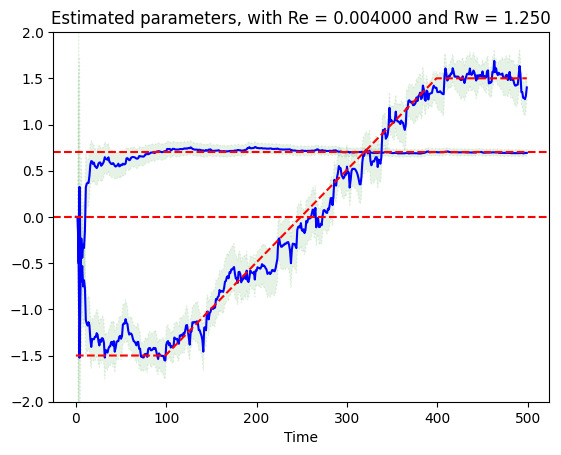

final xT value: [1.40165076 0.69269606]
sse: 604.0


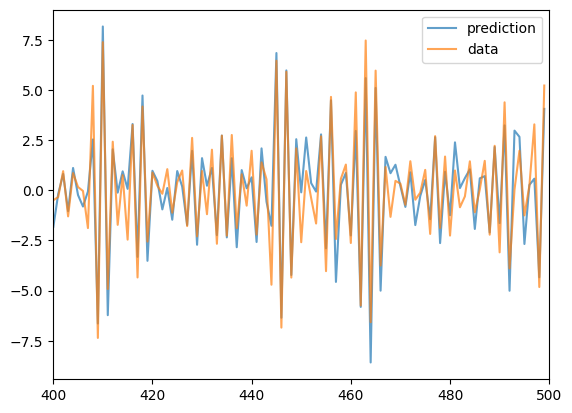

In [44]:
#Write your code for task 2.2
y = tar2
N = len(y)

# Estimate the unknown parameters using a Kalman filter.
p0 = 2                                              # Number of unknowns in the A polynomial.
q0 = 0                                              # Number of unknowns in the C polynomial.

A     = np.eye(p0 + q0)
Rw    = 1.25
Re    = np.array([[0.004, 0], [0, 0]])
Rx_t1 = 10 * np.eye(2)
h_et  = np.zeros(N)                                 # Estimated one-step prediction error.
e_filt = np.zeros(N)                                # Store the residual
xt    = np.zeros((p0 + q0, N))                      # Estimated states. Intial state, x_{1|0} = 0.
yhat  = np.zeros(N)                                 # Estimated output.
xStd  = np.zeros((p0 + q0, N))                      # Stores one std for the one-step prediction.
yStd  = np.zeros(N)       
                          # Stores one std for the one-step prediction.
for t in range(3, N):                               # We use t-3, so start at t=4.
    # Update the predicted state and the time-varying state vector.
    x_t1 = A @ xt[:, t-1]                           # x_{t|t-1} = A x_{t-1|t-1}
    C    = np.array([[-y[t-1], -y[t-2]]])  # Use earlier prediction errors as estimate of e_t.
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                       # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry                           # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]                         # One-step prediction, \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat[t]                        # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]            # x_{t|t}= x_{t|t-1} + K_t ( y_t - Cx_{t|t-1} )

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T                  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re                     # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re

    # Estimate a one std confidence interval of the estimated parameters.
    # This is only for the plots.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))             # This is one std for each of the parameters for the one-step prediction.

    # Estimate a one std confidence interval of the one-step prediction.
    yStd[t] = np.sqrt(Ry[0, 0])                     # As the output is scalar, Ry is too.




### Plotting

# Examine the estimated parameters.
# As with the command present, the precision is given with +/- one std.
from tsa_lth.analysis import plotWithConf
plt.figure()
plotWithConf(np.arange(N), xt.T, xStd.T, thx.mean(axis=0))   # or thx.T depending on shape
plt.plot(thx[:, 0], color='red', zorder=10, label='true param', linestyle='--')
plt.title(f'Estimated parameters, with Re = {Re[0, 0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.ylim([-2, 2])
plt.show()

print(f'final xT value:', xt.T[-1])


# Prediction vs Data
plt.figure()
plt.plot(yhat, alpha=0.7, label='prediction')
plt.plot(y, alpha=0.7, label = 'data')
plt.xlim(400, 500)
plt.legend()
sse = np.sum(h_et[:]**2)
print(f"sse: {sse:.1f}")



**Question 2**

In Mozquizto, answer question 2.

This question strives to check that your implementation is correct. As you will use this as the basis for the following steps, as well as in the project, it is important that you get this to work properly. Ask the teaching staff to help you if you do not get the correct answer!

**Question 3**

In Mozquizto, answer question 3.

What effect has the choice of `Rw` and `Re` for the parameter estimates? Did you manage to improve the estimation by using Kalman filtering instead of RLS? Can you reduce the sum of the squared residual (`ehat`) by tuning `Re` and `Rw`?

## 2.3 Using the Kalman filter for prediction

We now proceed to form a 2-step prediction using the Kalman filter. To do this, you need to complete the latter part of the example code. As it can be difficult to verify that the implementation is correct, we will use simulated data for this. To be able to check your implementation, use
```python
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])
y  = signal.lfilter([1], A0, ee)
Re = np.array([[1e-6, 0], [0, 1e-6]])
Rw = 0.1
```
We here select `Re` small to ensure that we get states that converge close to the true values (which is also why we select $N$ so large).

In order to form $\hat{y}_{t+2|t}$, you first need to form $\hat{C}_{t+2|t}$, as
$$
\hat{y}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t+2|t} = \hat{C}_{t+2|t} \hat{x}_{t|t}
$$
Note that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$. Why does this equality hold here?

Proceed to write down an expression for $\hat{C}_{t+2|t}$ and note that this will depend on $\hat{y}_{t+1|t}$. As a result, you will first need to estimate $\hat{y}_{t+1|t}$, then use this value to form $\hat{C}_{t+2|t}$, and then finally use this to form $\hat{y}_{t+2|t}$. Update the example code with the missing lines.

To examine the predictions when the filter has converged, use the following code to plot the last 100 samples of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$.
```python
indV = range(N-102, N-1)
plt.plot(indV, [y[indV], yhat1[indV], yhat2[indV]])
plt.legend(['y_t', 'y_{t|t-1}', 'y_{t+2|t}'])
plt.title('Data vs predictions')
plt.xlabel('Time')
plt.xlim([indV[0], indV[-1]])
```
Notice that the plot stops at $N-2$. Why is that?

Plot the estimated states and check that they converge properly.

In [69]:
#write your code for task 2.3

# Simulate the data
np.random.seed(0)
N  = 10000
ee = 0.1 * np.random.randn(N)
A0 = np.array([1, -0.8, 0.2])
y  = signal.lfilter([1], A0, ee)


In [90]:
# Setup for k-step prediction. This code assumes that k<7 (otherwise, change line 80).
k = 2
p0 = 2  # Number of unknowns in the A polynomial (note: this is only the non-zero parameters!).
q0 = 0  # Number of unknowns in the C polynomial (note: this is only the non-zero parameters!).

A = np.eye(p0 + q0)
Re = np.array([[1e-10, 0], [0, 1e-10]])
Rw = 0.001
Rx_t1 = np.eye(p0 + q0)  # Initial covariance matrix, R_{1|0}^{x,x}
Rx_k = Rx_t1.copy()
h_et = np.zeros(N)  # Estimated one-step prediction error.
ehat1 = np.zeros(N)  # Estimated one-step prediction error.
ehat2 = np.zeros(N)  # Estimated one-step prediction error.
xt = np.zeros((p0 + q0, N - k))  # Estimated states. Intial state, x_{1|0} = 0.
yhat = np.zeros(N - k)  # Estimated output.
yhat1 = np.zeros(N)  # Estimated k-step prediction.
yhat2 = np.zeros(N)  # Estimated k-step prediction.
xStd = np.zeros((p0 + q0, N - k))  # Stores one std for the one-step prediction.
xStdk = np.zeros((p0 + q0, N - k))  # Stores one std for the k-step prediction.

In [93]:
# Kalman loop

for t in range(2, N - k):  # t=8 in MATLAB (1-indexed) is t=7 in Python (0-indexed)
    # Update the predicted state and the time-varying state vector.
    x_t1 = A @ xt[:, t - 1]  # x_{t|t-1} = A x_{t-1|t-1}
    C = np.array([[-y[t-1], -y[t-2]]])  # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw  # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry  # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]  # One-step prediction, \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat[t]  # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}
    xt[:, t] = x_t1 + (Kt * h_et[t]).flatten()  # x_{t|t}= x_{t|t-1} + K_t ( y_t - Cx_{t|t-1} )
    
    # Update the covariance matrix estimates.
    Rx_t = Rx_t1 - Kt @ Ry @ Kt.T  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re  # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re
    
    # Form the k-step prediction by first constructing the future C vector
    # and the one-step prediction. Note that this is not yhat(t) above, as
    # this is \hat{y}_{t|t-1}.
  
    # Predicting 1 step ahead
    Ck = np.array([[-y[t], -y[t-1]]]) # C_{t+1|t}
    yk = (Ck @ xt[:, t])[0]  # \hat{y}_{t+1|t} = C_{t+1|t} A x_{t|t}
    yhat1[t + 1] = yk
    ehat1[t+1] = y[t+1] - yk

    # Predidcting 2 steps ahead
    Ck = np.array([[-yk, -y[t]]])
    yk = (Ck @ xt[:, t])[0] 
    yhat2[t + 2] = yk
    ehat2[t+2] = y[t+2] - yk
    
    # Estimate a one std confidence interval of the estimated parameters.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))  # This is one std for each of the parameters for the one-step prediction.
    xStdk[:, t] = np.sqrt(np.diag(Rx_k))  # This is one std for each of the parameters for the k-step prediction.

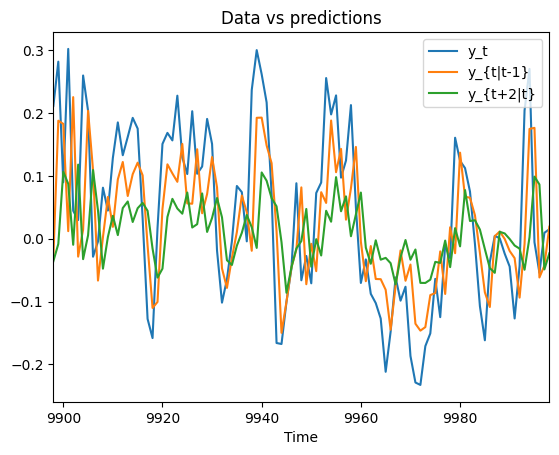

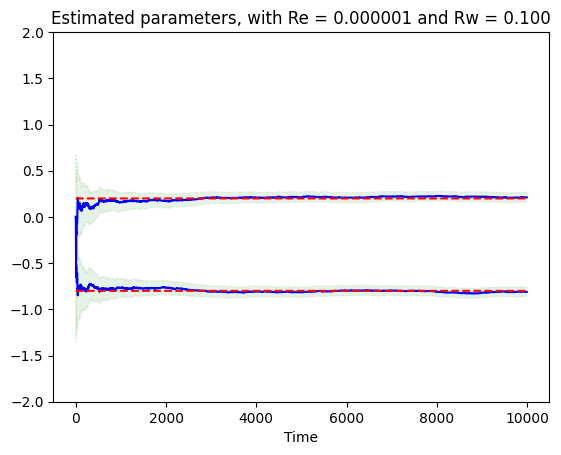

[-0.81122798  0.21171181]


In [79]:

# View predictions
indV = range(N-102, N-1)
plt.plot(indV, y[indV])
plt.plot(indV, yhat1[indV])
plt.plot(indV, yhat2[indV])
plt.legend(['y_t', 'y_{t|t-1}', 'y_{t+2|t}'])
plt.title('Data vs predictions')
plt.xlabel('Time')
plt.xlim([indV[0], indV[-1]])


# See convergence of states
plt.figure()
plotWithConf(np.arange(N-2), xt.T, xStd.T)
plt.plot([0.2] * len(xt.T), color='red', zorder=10, label='true param', linestyle='--')
plt.plot([-0.8] * len(xt.T), color='red', zorder=10, label='true param', linestyle='--')
plt.title(f'Estimated parameters, with Re = {Re[0, 0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.ylim([-2, 2])
plt.show()

print(xt[:, -1])


**Question 4**

In Mozquizto, answer question 4.

Again, it is important as you get your code to work properly as you will use this code in the project. Ask the teaching staff if you have problems!


### Discussion
Compute the sum of the squared prediction residual for the last 100 samples (why not all?). Can you improve the estimate, i.e., lower the sum of the squared prediction residual by tuning the choice of `Rw` and `Re`?

Show the plot of $y_t$, $\hat{y}_{t|t-1}$, and $\hat{y}_{t+2|t}$, as well of the predicted states, to the teaching staff. Why is it that, in general, $\hat{x}_{t+2|t} \neq \hat{x}_{t|t}$?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

In [89]:
ss1 = np.sum([v**2 for v in ehat1[-100:]])
print(f'ss1: {ss1}')
ss2 = np.sum([v**2 for v in ehat2[-100:]])
print(f'ss2: {ss2}')

ss1: 0.9401461427631195
ss2: 1.6060084663466756


It is worth noting that in case you are using the Kalman filter to predict an MA or an ARMA process, your `C` vector will contain earlier noise values, i.e., $e_t$, $e_{t-1}$, etc. These noise values are obviously not known, so one then use the corresponding one-step prediction errors in place of these, i.e., $\epsilon_{t|t}$, $\epsilon_{t-1|t-1}$, etc. These values are here stored in the variable `ehat`.

*Important:* Note that when using the Kalman filter for prediction, you *should not* use the polynomial division techniques discussed in the earlier computer exercise, as presented in Chapter 6 in the course textbook. This will not yield the correct estimates! Instead, predictions needs to be made by updating the states as indicated in Chapter 8.

## 2.4 Quality control of a process

In the quality control division at a factory, one has found that the process which is to be followed shows a drift like
$$
x_t = x_{t-1} + e_t .
$$
However, it is not possible to measure the quality variable $x_t$ exactly, and one instead is limited to the observations
$$
y_t = x_t + bu_t + v_t ,
$$
where the processes $e_t$ and $v_t$ are two mutually uncorrelated sequences of white noise, with the variances $\sigma_e^2$ and $\sigma_v^2$. Furthermore, $b$ is a parameter. For simplicity, we assume that the external signal $u_t$ is known.

Use the script written in the preparatory exercise for the computer exercise to simulate the process with the input signal $u_t$. Select $b=20$, $\sigma_e^2 = 1$ and $\sigma_v^2 = 4$, but feel free to change these at will. Now consider $x_t$ and $b$ to be unknown, and use the Kalman filter you prepared and implement a filter that estimates $b$. Plot your estimates of the hidden states together with the true values. Plot the one-step prediction $\hat{y}_{t|t-1}$ as compared to the measured signal $y_t$.

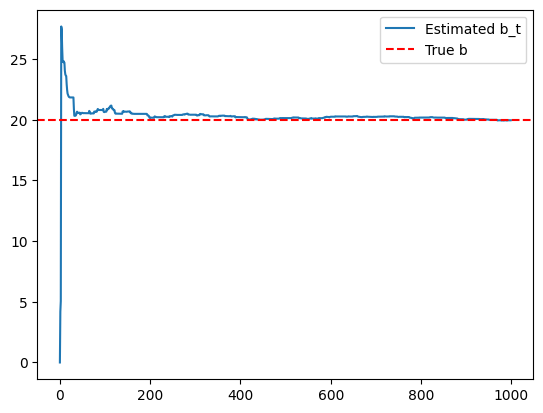

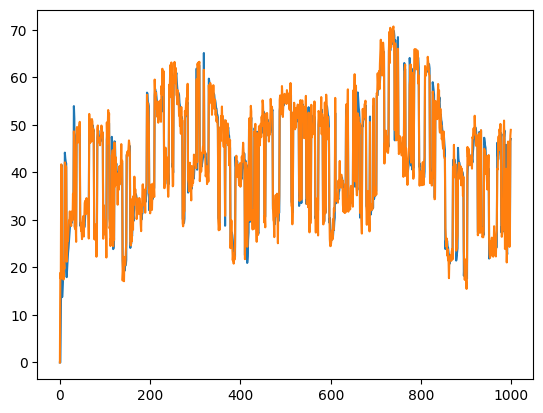

In [203]:
#write your code for task 2.4

"""
Write a Python script that simulates the process $u_t$ in Section 2.4 below. 
Let $u_t$ be a Markov chain that switches slowly between two states, using $p_{11}=p_{22}=7/8$ and $p_{12}=p_{21}=1/8$.
"""

def simulate_ut(N, pmatrix, init_state=1):
    ut = []
    state = init_state
    for n in range(N):
        if state == 1:
            random_num = np.random.rand()
            if random_num >= pmatrix[0][0]:
                state = 2
        elif state == 2:
            random_num = np.random.rand()
            if random_num <= pmatrix[1][0]:
                state = 1
        ut.append(state)
    return np.array(ut)

# --- Parameters ---
N = 1000
pmatrix = [[7/8, 1/8], [1/8, 7/8]]
b = 20
var_e = 1
var_v = 4

# --- Simulate ---
ut = simulate_ut(N, pmatrix, init_state=1)
e = np.sqrt(var_e) * np.random.randn(N)
v = np.sqrt(var_v) * np.random.randn(N)
x = np.zeros(N)
y = np.zeros(N)

for t in range(1, N):
    x[t] = x[t-1] + e[t]
    y[t] = x[t] + b * ut[t] + v[t]


# Kalman Filter
def kalman_estimate_b(y, u, sigma_e2=1.0, sigma_v2=4.0, q_b=1e-6):
    """
    Estimate b in y_t = x_t + b*u_t + v_t
    where x_t = x_{t-1} + e_t, using a Kalman filter.
    """

    N = len(y)

    # --- Define model matrices ---
    A = np.eye(2)                                    # State transition matrix
    Re = np.diag([sigma_e2, q_b])                    # System noise covariance matrix, R_e
    Rw = sigma_v2                                    # Measurement noise covariance matrix, R_w

    # --- Initialize ---
    xhat_t1 = np.zeros(2)                            # Initial state, x_{1|0} = [x0, b0]
    Rx_t1 = 1e3 * np.eye(2)                          # Initial covariance, R_{1|0}^{x,x}
    xhat = np.zeros((2, N))                          # Store estimated states
    yhat = np.zeros(N)                               # One-step prediction, \hat{y}_{t|t-1}
    h_et = np.zeros(N)                               # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}

    # --- Kalman filter recursion ---
    for t in range(N):

        # 1. Time update (Prediction)
        x_t1 = A @ xhat_t1                           # x_{t|t-1} = A x_{t-1|t-1}
        Rx_t_t1 = A @ Rx_t1 @ A.T + Re               # R_{t|t-1}^{x,x} = A R_{t-1|t-1}^{x,x} A^T + R_e

        # 2. Measurement update (Correction)
        C = np.array([[1.0, u[t]]])                  # Measurement matrix, C_t
        Ry = C @ Rx_t_t1 @ C.T + Rw                  # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} C^T + R_w
        Kt = Rx_t_t1 @ C.T / Ry                      # Kalman gain, K_t = R^{x,x} C^T inv(R^{y,y})

        yhat[t] = (C @ x_t1)[0]                      # One-step prediction, \hat{y}_{t|t-1}
        h_et[t] = y[t] - yhat[t]                     # One-step prediction error, \hat{e}_t

        x_t = x_t1 + (Kt.flatten() * h_et[t])        # x_{t|t} = x_{t|t-1} + K_t * \hat{e}_t
        Rx_t = Rx_t_t1 - Kt @ Ry @ Kt.T              # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R^{y,y}_{t|t-1} K_t^T

        # 3. Prepare for next iteration
        xhat[:, t] = x_t
        xhat_t1 = x_t
        Rx_t1 = Rx_t

    return xhat[0, :], xhat[1, :], yhat, h_et


xhat, bhat, yhat, h_et = kalman_estimate_b(y, ut, sigma_e2=var_e, sigma_v2=var_v)



plt.figure()
plt.plot(bhat, label='Estimated b_t')
plt.axhline(20, color='r', linestyle='--', label='True b')
plt.legend()
plt.show()

plt.figure()
plt.plot(yhat, label='1-step pred')
plt.plot(y, label='data')



### Discussion
How should the state space vector be chosen? How would you choose an initial value of `Re` and `Rw`? How can then proceed to fine-tune the filter?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

## 2.5 Recursive temperature modeling

The file `svedala94.mat` contains temperature measurements from the Swedish city Svedala, taken every four hours throughout 1994.

One potential model to describe the temperature with can be a SARIMA$(2,0,2)\times(0,1,0)_6$ process, i.e., $A(z)\nabla_6 y_t = C(z)e_t$, where the $A(z)$ and $C(z)$ polynomials are of order 2.

### 1. Plot the temperature and differentiated data

Plot the temperature, differentiate the process to form $\nabla_6 y_t$ (use `signal.lfilter` and remember those initial samples) and plot the differentiated temperature. To obtain months on the x-axis, use
```python
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(svedala94))
plt.plot(T, svedala94)
```

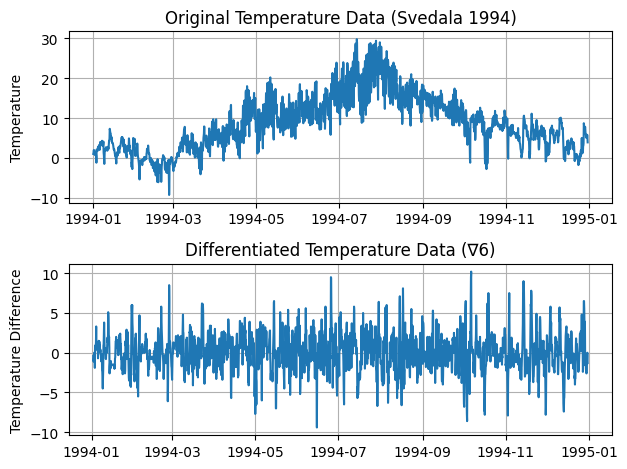

In [9]:
# Load svedala94 data
mat_data = sio.loadmat('../data/svedala94.mat')
y = mat_data['svedala94'].flatten()

nab6 = [1, 0, 0, 0, 0, 0, -1]
ydiff = signal.lfilter(nab6, [1], y)
ydiff = ydiff[len(nab6):]

# Create time vector
T = pd.date_range(start='1994-01-01', end='1994-12-31', periods=len(y))


plt.subplot(211)
plt.plot(T, y)
plt.title('Original Temperature Data (Svedala 1994)')
plt.ylabel('Temperature')
plt.grid(True)

plt.subplot(212)
plt.plot(T[len(nab6):], ydiff)
plt.title('Differentiated Temperature Data (∇6)')
plt.ylabel('Temperature Difference')
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. Estimate model parameters for different periods

Determine your own model for the first 540 samples. One potential model could be an ARMA(3,6), formed as
$$
\nabla_6 ( 1 + a_1 z^{-1} + a_2 z^{-2} + a_3 z^{-3})y_t = (1 + c_6 z^{-6}) e_t
$$
Did you get a similar model? To allow comparisons, we will now use the above ARMA(3,6) model. Estimate the parameters for this model for a) the winter (say, January to March, i.e., samples 1 to 540), b) summer (say, June to August, i.e., samples 907 to 1458), and c) for the entire year. Compare the different estimated parameters. Do they seem to change? Does the model seem to work reasonably throughout the year?

Discrete-time ARMA model: A(z)∇₆y(t) = C(z)e(t)

A(z) = 1.0 - 1.0336(±0.0429)·z⁻¹ + 0.2822(±0.0607)·z⁻² - 0.1633(±0.0431)·z⁻³
C(z) = 1.0 - 0.9053(±0.0216)·z⁻⁶

Polynomial orders: nA = 3    nC = 6
Number of free coefficients: 4
Fit to estimation data (NRMSE): 65.18%
FPE : 0.971  MSE : 0.958
AIC : 1500.682   BIC : 1517.803



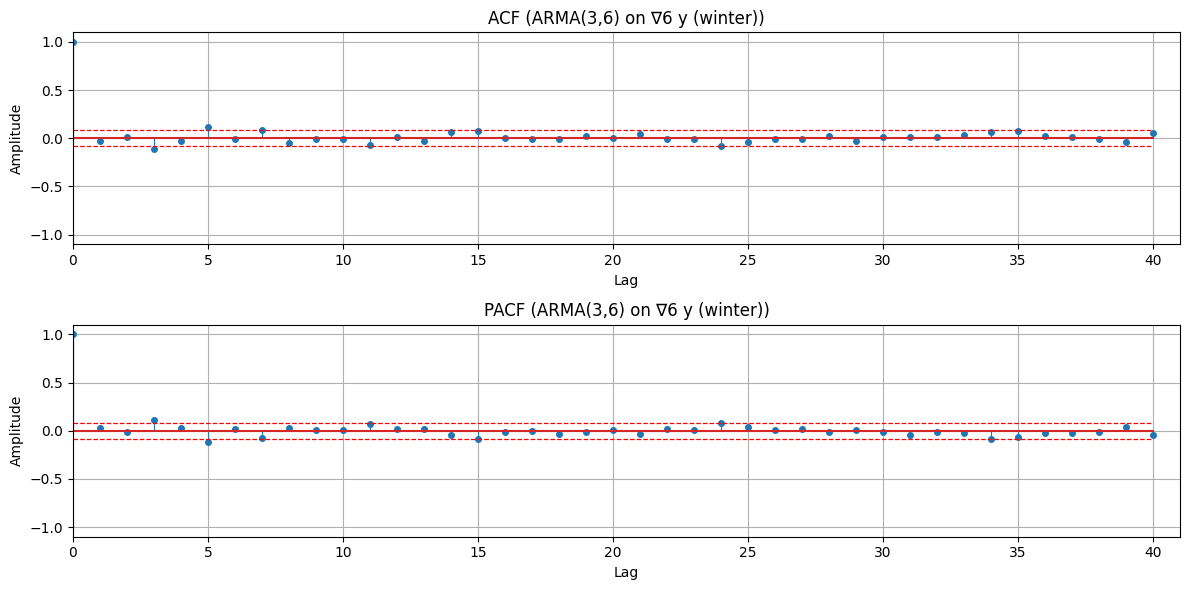

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 34.56 < 37.65)
  McLeod-Li test:        False (white if 54.13 < 37.65)
  Monti test:            True (white if 33.34 < 37.65)
  Sign change test:      True (white if 0.47 in [0.46,0.54])


In [10]:
ysample = y[0:540]
# ysample = y[907:1458]
# ysample = y[:]

A_order = 3
C_order = 6

A_free = [0,1,1,1] 
C_free = [0,0,0,0,0,0,1]          

model = estimateARMA(
    ysample,
    A=A_order,
    C=C_order,
    diff=6,                       
    A_free=A_free,
    C_free=C_free,
    titleStr='ARMA(3,6) on ∇6 y (winter)',
    noLags=40,
    method='LS',
    bh=False,
    plot=True
)


### 3. One-step prediction using winter model

Use the winter model to form a one-step prediction of the temperature for the validation data, here the last 400 samples, i.e., samples 1790 to 2190. To do so, add in the differentiated season in the model before computing the $G(z)$ polynomial to ensure that the prediction is formed in the correct domain. Apply the resulting filter to the *entire* signal. Then, cut out the part of the prediction that forms the validation data (this way you avoid any initialization problems). Plot the ACF of the resulting prediction residual for the validation data and compute its variance.

A polynomial (with differentiation): [ 1.         -1.03360974  0.28218421 -0.16333638  0.          0.
 -1.          1.03360974 -0.28218421  0.16333638]
C polynomial: [ 1.       0.       0.       0.       0.       0.      -0.90535]

F = [1.]
G = [ 0.          1.03360974 -0.28218421  0.16333638  0.          0.
  0.09465    -1.03360974  0.28218421 -0.16333638]

Prediction complete. Shape: (400,)
Original variance: 8.635844724022148
Residual variance: 1.1118235794504847


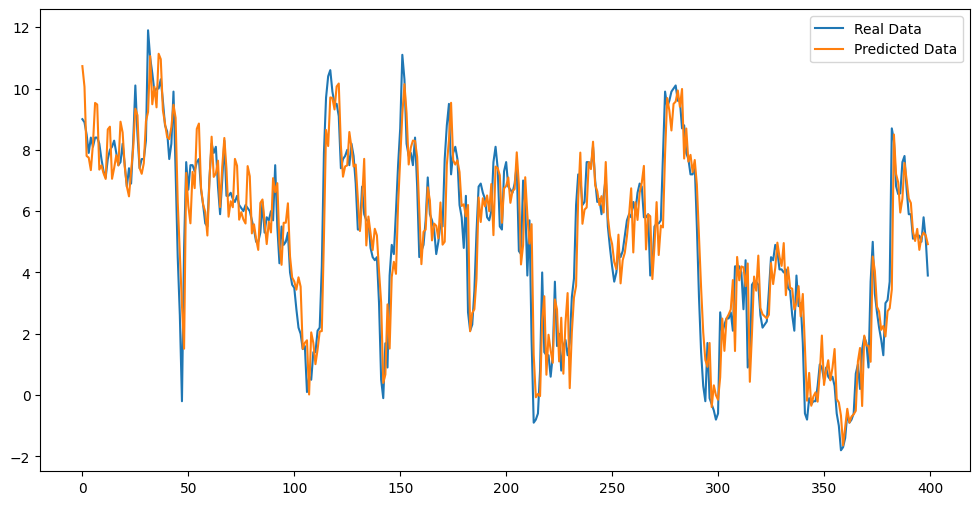

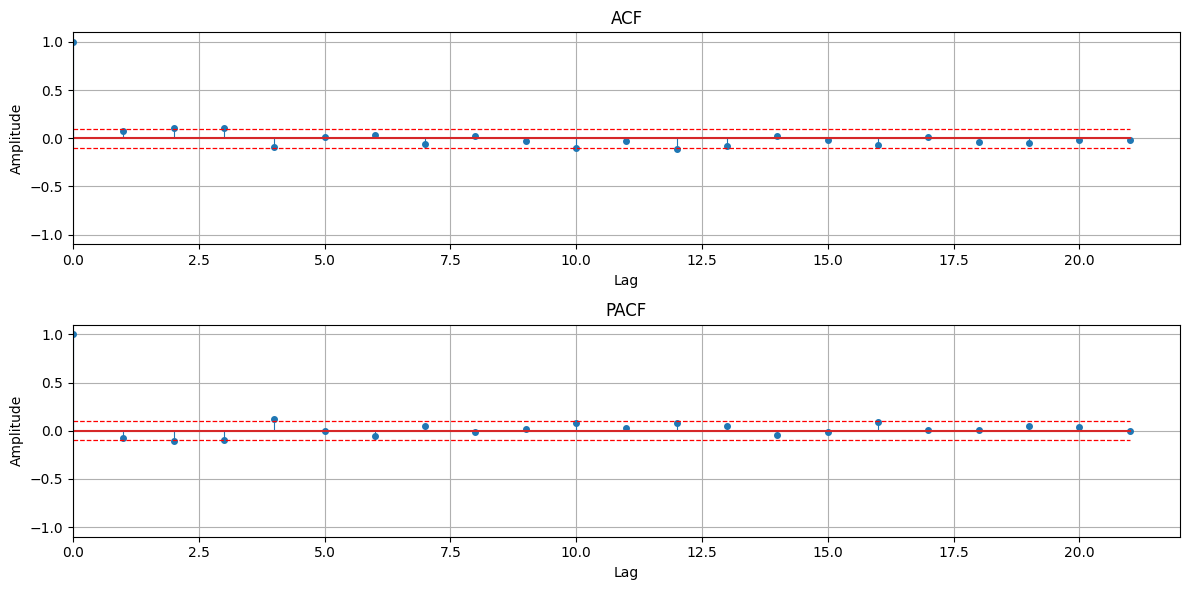

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 38.75 < 37.65)
  McLeod-Li test:        True (white if 14.37 < 37.65)
  Monti test:            False (white if 37.96 < 37.65)
  Sign change test:      True (white if 0.46 in [0.45,0.55])


In [147]:
#write your code for task 2.5.3

# Setup
k = 1
valid_idxs = slice(1790, 2190)
# valid_idxs = slice(None, None)

validation_data = y[valid_idxs]

# Form the A polynomial taking the differentiation into account
A_full = np.convolve([1, 0, 0, 0, 0, 0, -1], model.A)
print(f"A polynomial (with differentiation): {A_full}")
print(f"C polynomial: {model.C}")

# Compute the G and F polynomials
F, G = polydiv(model.C, A_full, k)
print(f"\nF = {F}")
print(f"G = {G}")

# Form the predicted data
pred_validation = signal.lfilter(G, model.C, y)
pred_validation = pred_validation[valid_idxs]

print(f"\nPrediction complete. Shape: {pred_validation.shape}")

# Plot prediction vs real data
plt.figure(figsize=(12, 6))
plt.plot(validation_data, label='Real Data')
plt.plot(pred_validation, label='Predicted Data')
plt.legend()

# Residuals
residuals = validation_data - pred_validation
print(f'Original variance: {np.var(validation_data)}')
print(f'Residual variance: {np.var(residuals)}')

from tsa_lth.modelling import whiteness_test
plotACFnPACF(residuals)
whiteness_test(residuals)


### 4. Kalman filter estimation throughout the year

Use the Kalman filter to estimate the parameters of the ARMA(3,6) model throughout the year. To do so requires some care. To begin with, do not remove the initial samples when forming $z_t = \nabla_6 y_t = y_t - y_{t-6}$. Clearly, these initial samples will be corrupted, as always, but we will instead remove these later to simplify the alignment of the vectors. Then, form the Kalman filter predict $\hat{z}_{t|t-1}$ using the ARMA structure above using the appropriate `C` vector. As
$$
 \hat{y}_{t|t-1}=  \hat{z}_{t|t-1} + y_{t-6}
$$
you can reconstruct $\hat{y}_{t|t-1}$ using:
```python
zt = C @ x_t1                # \hat{z}_{t|t-1}
yhat[t] = zt + y[t-6]        # \hat{y}_{t|t-1}
```
Next, you can initiate the model at the beginning of the data set using the parameters you have found from the modeling data. To make the plots a bit nicer, we do this also for the states before the predictions:
```python
xt = np.zeros((p0+q0, N))
for k in range(6):
    xt[:, k] = np.concatenate([winterModel.A[1:], [winterModel.C[-1]]])
```
Here, the parameters `p0` and `q0` indicate the number of unknown coefficients in the $A(z)$ and $C(z)$-polynomials, respectively. As this choice of initial states should be fairly accurate, you trust your initial estimates to be reasonably good and can thus select a low initial $R_{1|0}^{x,x}$, for instance using
```python
Rx_t1 = 1e-5 * np.eye(p0+q0)
Re    = 1e-5 * np.eye(p0+q0)
Rw    = 2
```
where we have also selected rather low values for $R_w$ and $R_e$; try using some different values to get a feel for how these choices affect the resulting estimates and if you can improve the quality of the estimates. Note that you can (and maybe should?) have different parameter variances.

Compare the resulting prediction with the result you got above when using the winter model as well as with the naive predictor. As you can see, the winter model is actually rather stable and actually works quite well even for the validation data, even without allowing the parameters to vary. Can you suggest any reasons why this might be?

In [18]:
# --- TRIAL 2: CLEAN START ---
for var in [
    "use_simulated_data", "mat_data", "y", "z", "N", "p0", "q0", "n_states",
    "initial_state", "A", "Re", "Rw", "Rx_t1", "xt", "yhat", "zhat", "ehat",
    "ehat_buffer", "t", "x_prev", "x_t1", "Rxx_t1", "C_t", "Ryy", "K_t", "Rx_t",
]:
    if var in locals():
        del locals()[var]



# Simulate N samples of a process to test your code.
use_simulated_data = False

if use_simulated_data:
    from tsa_lth.modelling import simulateARMA
    z = simulateARMA(AR=[1, 1, 1, 1], MA=[1,0,0,0,0,0,1], size=10_000)                    # Simulated data 
else:
    mat_data = sio.loadmat('../data/svedala94.mat')
    y = mat_data['svedala94'].flatten()        
    z = signal.lfilter([1, 0, 0, 0, 0, 0, -1], [1], y)

# Setup
N = len(z)
p0 = 3
q0 = 1
n_states = p0 + q0
initial_state = np.concatenate([model.A[1:], [model.C[-1]]])
print(f'Initial state from Winter model: {initial_state}')

# Define the state space equations. 
A   = np.eye(p0 + q0)
Re  = 1e-6 * np.eye(p0+q0)                     # State covariance matrix
Rw  = 2                     # Observation variance

# Set some initial values
Rx_t1 = 1e-6 * np.eye(p0+q0)       # R_{1|0}^{x,x}
                  
# Storage arrays
xt = np.zeros((n_states, N))
yhat = np.zeros(N)
zhat = np.zeros(N)
ehat  = np.zeros(N)         # Estimated prediction error.

# Initialize first 6 states with model parameter estimates
for k in range(7):
    xt[:, k] = initial_state.copy()

# Initialize ehat with small values for the MA part
ehat_buffer = np.zeros(N)

# Where should the loop start and stop?
for t in range(7, N):


    x_prev = xt[:, t-1] # Previous state estimate
    x_t1 = A @ x_prev # Predicted state

    # Update state covariance
    Rxx_t1 = A @ Rx_t1 @ A.T + Re

    # Form C Vector for ARMA(3,6)
    C_t = np.array([-z[t-1], -z[t-2], -z[t-3], ehat_buffer[t-6]])

    # Predict z_t and y_t 
    zhat[t] = C_t @ x_t1
    yhat[t] = zhat[t] + y[t-6]

    # Prediction error
    ehat[t] = y[t] - yhat[t]
    ehat_buffer[t] = z[t] - zhat[t]

    # Innovation covariance
    Ryy = C_t @ Rxx_t1 @ C_t.T + Rw

    # Kalman gain
    K_t = Rxx_t1 @ C_t / Ryy

    # Update state
    xt[:, t] = x_t1 + K_t * (z[t] - zhat[t])

    # Update state covariance
    Rx_t = Rxx_t1 - np.outer(K_t, K_t) * Ryy

    # Prepare for next iteration
    Rx_t1 = Rx_t




print('Kalman Filter Results:')
print(f'Final a1: {xt[0, -1]:.4f}')
print(f'Final a2: {xt[1, -1]:.4f}')
print(f'Final a3: {xt[2, -1]:.4f}')
print(f'Final c6: {xt[3, -1]:.4f}')
 

Initial state from Winter model: [-1.03360974  0.28218421 -0.16333638 -0.90535   ]
Kalman Filter Results:
Final a1: -0.9953
Final a2: 0.2507
Final a3: -0.1524
Final c6: -0.7623



### 5. Multi-step predictions

Proceed to plot the 2-step and 3-step predictions of the temperature data. It is worth noting that the 3-step prediction will need to use the 2-step prediction. Compute the variance of the corresponding prediction residuals.

Initial state from Winter model: [-1.03360974  0.28218421 -0.16333638 -0.90535   ]
Kalman Filter Results:
Final a1: 0.0000
Final a2: 0.0000
Final a3: 0.0000
Final c6: 0.0000
Residual variance for 1-step: 2.7176
Residual variance for 2-step: 4.4175
Residual variance for 3-step: 4.9057


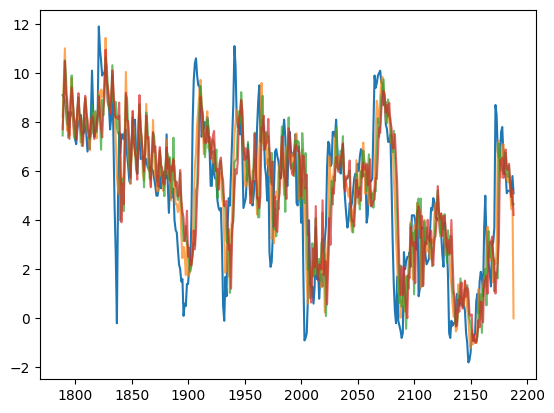

In [ ]:
# --- TRIAL 2: CLEAN START ---
for var in [
    "use_simulated_data", "mat_data", "y", "z", "N", "p0", "q0", "n_states",
    "initial_state", "A", "Re", "Rw", "Rx_t1", "xt", "yhat", "zhat", "ehat",
    "ehat_buffer", "t", "x_prev", "x_t1", "Rxx_t1", "C_t", "Ryy", "K_t", "Rx_t",
]:
    if var in locals():
        del locals()[var]



# Simulate N samples of a process to test your code.
use_simulated_data = False

if use_simulated_data:
    from tsa_lth.modelling import simulateARMA
    z = simulateARMA(AR=[1, 1, 1, 1], MA=[1,0,0,0,0,0,1], size=10_000)                    # Simulated data 
else:
    mat_data = sio.loadmat('../data/svedala94.mat')
    y = mat_data['svedala94'].flatten()        
    z = signal.lfilter([1, 0, 0, 0, 0, 0, -1], [1], y)

# Setup
N = len(z)
p0 = 3
q0 = 1
n_states = p0 + q0
initial_state = np.concatenate([model.A[1:], [model.C[-1]]])
print(f'Initial state from Winter model: {initial_state}')

# Define the state space equations. 
A   = np.eye(p0 + q0)
Re  = 1e-6 * np.eye(p0+q0)                     # State covariance matrix
Rw  = 2                     # Observation variance

# Set some initial values
Rx_t1 = 1e-6 * np.eye(p0+q0)       # R_{1|0}^{x,x}
                  
# Storage arrays
xt = np.zeros((n_states, N))
yhat = np.zeros(N)
zhat = np.zeros(N)
yhat1 = np.zeros(N)
yhat2 = np.zeros(N)
yhat3 = np.zeros(N)
ehat  = np.zeros(N)         # Estimated prediction error.

# Initialize first 6 states with model parameter estimates
for k in range(7):
    xt[:, k] = initial_state.copy()

# Initialize ehat with small values for the MA part
ehat_buffer = np.zeros(N)

# Where should the loop start and stop?
for t in range(7, N-3):


    x_prev = xt[:, t-1] # Previous state estimate
    x_t1 = A @ x_prev # Predicted state

    # Update state covariance
    Rxx_t1 = A @ Rx_t1 @ A.T + Re

    # Form C Vector for ARMA(3,6)
    C_t = np.array([-z[t-1], -z[t-2], -z[t-3], ehat_buffer[t-6]])

    # Predict z_t and y_t 
    zhat[t] = C_t @ x_t1
    yhat[t] = zhat[t] + y[t-6]

    # Prediction error
    ehat[t] = y[t] - yhat[t]
    ehat_buffer[t] = z[t] - zhat[t]

    # Innovation covariance
    Ryy = C_t @ Rxx_t1 @ C_t.T + Rw

    # Kalman gain
    K_t = Rxx_t1 @ C_t / Ryy

    # Update state
    xt[:, t] = x_t1 + K_t * (z[t] - zhat[t])

    # Update state covariance
    Rx_t = Rxx_t1 - np.outer(K_t, K_t) * Ryy

    # Prepare for next iteration
    Rx_t1 = Rx_t


    # 1-step Prediction
    C_t1 = np.array([-zhat[t], -z[t-1], -z[t-2], ehat_buffer[t-5]])
    zhat_t1 = C_t1 @ xt[:, t]
    yhat_t1 = zhat_t1 + y[t-5]
    yhat1[t+1] = yhat_t1

    # 2-step Prediction
    C_t2 = np.array([-zhat_t1, -z[t], -z[t-1], ehat_buffer[t-4]])
    zhat_t2 = C_t2 @ xt[:, t]
    yhat_t2 = zhat_t2 + y[t-4]
    yhat2[t+2] = yhat_t2

    # 3-step Prediction
    C_t2 = np.array([-zhat_t2, -zhat_t1, -z[t], ehat_buffer[t-3]])
    zhat_t3 = C_t2 @ xt[:, t]
    yhat_t3 = zhat_t3 + y[t-3]
    yhat3[t+3] = yhat_t3





# Why did they become 0?
print('Kalman Filter Results:')
print(f'Final a1: {xt[0, -1]:.4f}')
print(f'Final a2: {xt[1, -1]:.4f}')
print(f'Final a3: {xt[2, -1]:.4f}')
print(f'Final c6: {xt[3, -1]:.4f}')
 

val_slice = slice(1789, 2189)
idx = np.arange(*valid_idxs.indices(len(z)))
ehat1_val = y[val_slice] - yhat1[val_slice]
ehat2_val = y[val_slice] - yhat2[val_slice]
ehat3_val = y[val_slice] - yhat3[val_slice]

print(f'Residual variance for 1-step: {np.var(ehat1_val):.4f}')
print(f'Residual variance for 2-step: {np.var(ehat2_val):.4f}')
print(f'Residual variance for 3-step: {np.var(ehat3_val):.4f}')

plt.figure()
plt.plot(idx, y[val_slice], label='data')
plt.plot(idx, yhat1[val_slice], label='1-step pred', alpha=0.7)
plt.plot(idx, yhat2[val_slice], label='2-step pred', alpha=0.7)
plt.plot(idx, yhat3[val_slice], label='3-step pred', alpha=0.7)





### Discussion

**Be prepared to show your parameter estimates and predictions when discussing with the examiner at the computer exercise!**

## 2.6 (optional) Examine the project data

Using the model for the input signal you developed in the second computer exercise, form a one-step prediction of this signal using a Kalman filter. Select the state covariances using the variance of the estimated prediction residual and the standard deviation of the parameter estimates you obtained in the second computer exercise. Initiate your parameters with the values you obtain in the second exercise.

Start the filtering at the beginning of the entire data set, to avoid any initialization and convergence effects, and then extract the predictions for the validation data. Is the prediction residual white? Compute the variance of the prediction residual. Plot the estimated parameters. Are these similar to the ones you had with the fixed model? Are some parameters very small in comparison to their standard deviations? Are they significant? Can you remove some parameters without increasing the variance of the prediction residual more than marginally? Do you get better estimates if you fix some of the parameters so that these are not allowed to vary, instead using the parameter value you had from the second exercise?

Form a $k$-step prediction of the input using the Kalman filter. Recall that you need to update the `C_t` vector at each step. How should you handle the future noise estimates? Examine the ACF of the prediction residual as well as its variance. Do you get a lower variance than you had for your fixed-parameter model?

*Hint:* You will typically perform these task as part of your project, so the time you spend on this now will be time saved later on...

## 3. Kalman Filter Outline

Below is an example of a Kalman filter implementation for reference.

In [ ]:
# Example of Kalman filter

# Simulate N samples of a process to test your code.
y = ?                       # Simulated data          

# Define the state space equations. 
A   = ?
Re  = ?                     # State covariance matrix
Rw  = ?                     # Observation variance

# Set some initial values
Rx_t1 = ? * np.eye(?)       # R_{1|0}^{x,x}
h_et  = np.zeros(?)         # Estimated prediction error.
xt    = np.zeros((?, ?))    # Estimated states. 
yhat1 = np.zeros(?)         # Estimated 1-step prediction.
yhat2 = np.zeros(?)         # Estimated 2-step prediction.

# Where should the loop start and stop?
for t in range(?, ?):

   # Update the predicted state 
    x_t1 = A @ xt[:, t-1]               # x_{t|t-1} 
    Ct = ?                              # C_{t|t-1}
    
    # Update the parameter estimates.
    Ry = ?                              # R_{t|t-1}^{y,y}
    Kt = ?                              # K_t
    yhat = Ct @ x_t1                    # \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat               # Prediction error,
    xt[:, t] = x_t1 + Kt * h_et[t]      # x_{t|t}

    # Update the covariance matrix estimates.
    Rx_t  = ?                           # R^{x,x}_{t|t}
    Rx_t1 = ?                           # R^{x,x}_{t+1|t} 

    # Form \hat{y}_{t+1|t}.
    Ct1 = ?                             # C_{t+1|t}
    yhat1[t+1] = Ct1 @ xt[:, t]         # \hat{y}_{t+1|t} 

    # Form \hat{y}_{t+2|t}.
    Ct2 = ?                             # C_{t+2|t}
    yhat2[t+2] = Ct2 @ xt[:, t]         # \hat{y}_{t+2|t}